# 4 - LSTM Model Training Notebook 

In [1]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/src')
import pandas as pd
import misc

%load_ext autoreload
%autoreload 2

Load the data

In [2]:
df = misc.load_processed_dataset("aapl", "2018-01-01", "2023-01-1")
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Close Forecast', 'Close_T-1', 'Close_T-2', 'Close_T-5', 'SMA_10',
       'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI_14',
       'upper_band', 'middle_band', 'lower_band', 'macd', 'macdsignal',
       'macdhist', 'OBV', 'ADX', 'AD', 'Aroon_down', 'Aroon_up', 'SlowK',
       'SlowD', 'Williams %R', 'pct_change', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'S&P Close'],
      dtype='object')

Feature selection

In [41]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Close Forecast', 'SMA_10',
       'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI_14',
       'upper_band', 'middle_band', 'lower_band', 'macd', 'macdsignal',
       'macdhist', 'OBV', 'ADX', 'AD', 'Aroon_down', 'Aroon_up', 'SlowK',
       'SlowD', 'Williams %R', 'pct_change', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'S&P Close']
features = ['Open', 'High', 'Low', 'Close', 'Volume']
Xs = df[features]
ys = df["Close Forecast"]

Normalisation

In [151]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xs_scaled = scaler.fit_transform(Xs.values)
ys_scaled = scaler.fit_transform(ys.values.reshape(-1,1))
Xs_scaled.shape, ys_scaled.shape


((1259, 5), (1259, 1))

Create sequences

In [152]:
import numpy as np

def create_sequences(Xs, ys, sequence_length):
    """
    Given a numpy array, create sequences of a fixed length, where
    each sequence will be used to predict the closing price of the next day.
    """
    X = []
    y = []
    for i in range(sequence_length, len(Xs)+1):
        X.append(Xs[i-sequence_length:i])
        y.append(ys[i-1])
    return np.array(X), np.array(y)

In [153]:
WINDOW_SIZE = 60
X, y = create_sequences(Xs_scaled, ys_scaled, WINDOW_SIZE)
X.shape, y.shape

((1200, 60, 5), (1200, 1))

Data prep

In [154]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_tensor = torch.tensor(X.astype(np.float32))
y_tensor = torch.tensor(y.astype(np.float32))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=False)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Model definition

In [155]:
import torch
import torch.nn as nn

class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockPriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [156]:
input_dim = 5  # Number of features
hidden_dim = 64  # Number of features in hidden state
num_layers = 2  # Number of stacked LSTM layers
output_dim = 1  # Number of output classes (predicting 'Close Forecast')

model = StockPriceLSTM(input_dim, hidden_dim, num_layers, output_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [157]:
num_epochs = 20  # Number of epochs

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Make sure labels are the correct shape
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/20, Loss: 0.2001529335975647
Epoch 2/20, Loss: 0.06089865043759346
Epoch 3/20, Loss: 0.02283555455505848
Epoch 4/20, Loss: 0.015023401938378811
Epoch 5/20, Loss: 0.005626204423606396
Epoch 6/20, Loss: 0.0053632138296961784
Epoch 7/20, Loss: 0.004463610239326954
Epoch 8/20, Loss: 0.004280067980289459
Epoch 9/20, Loss: 0.005378598812967539
Epoch 10/20, Loss: 0.004053651355206966
Epoch 11/20, Loss: 0.004766627214848995
Epoch 12/20, Loss: 0.004881410859525204
Epoch 13/20, Loss: 0.006073315162211657
Epoch 14/20, Loss: 0.005092384293675423
Epoch 15/20, Loss: 0.0035791608970612288
Epoch 16/20, Loss: 0.005304496269673109
Epoch 17/20, Loss: 0.0038667682092636824
Epoch 18/20, Loss: 0.0029979345854371786
Epoch 19/20, Loss: 0.0026683518663048744
Epoch 20/20, Loss: 0.003487558104097843


Model predictions

In [158]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Inference without calculating gradients
    predictions = []
    actuals = []
    for inputs, labels in test_loader:
        output = model(inputs)
        predictions.extend(output.view(-1).tolist())
        actuals.extend(labels.tolist())
    predictions = np.array(predictions)
    actuals = np.array(actuals)

predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_rescaled = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()


Visualisation

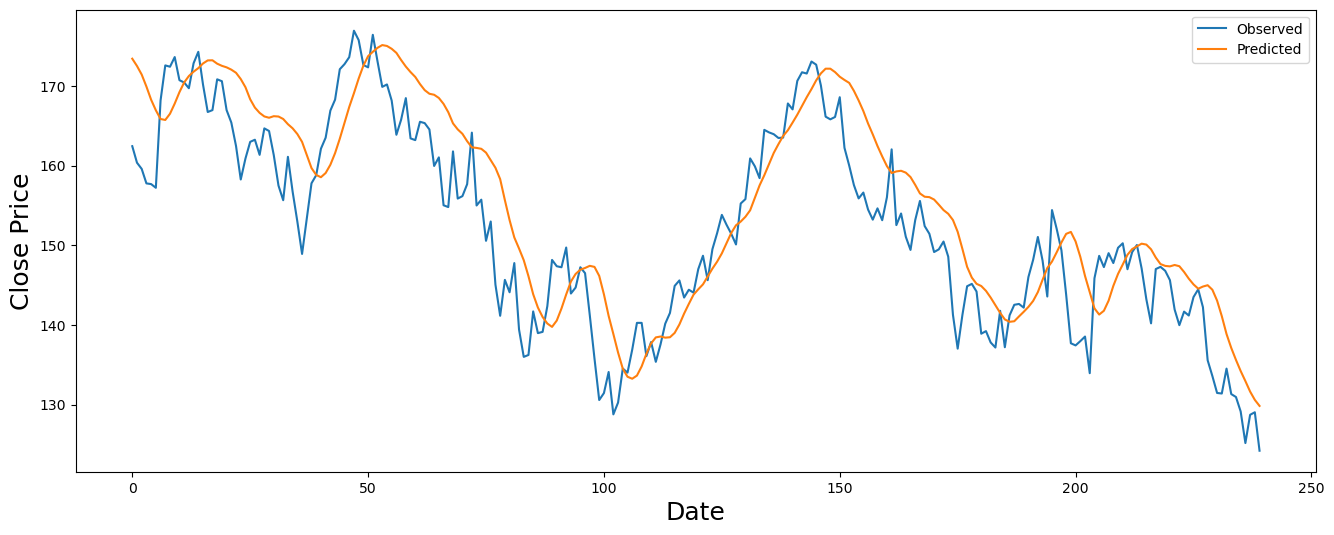

In [160]:
misc.plot(predictions_rescaled, actuals_rescaled)

Evaluate

In [161]:
misc.evaluate(predictions_rescaled, actuals_rescaled, verbose=True)

R^2: 0.7212888077698925
MSE: 43.09073724920907
RMSE: 6.56435352865833
MAE: 5.405663660613146
MAPE: 3.5990000522927916


(0.7212888077698925,
 43.09073724920907,
 6.56435352865833,
 5.405663660613146,
 3.5990000522927916)